In [1]:
# !pip -q install pandas numpy matplotlib scikit-learn scipy tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)


2025-12-16 10:56:30.818941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 10:56:30.858347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.20.0


2025-12-16 10:56:32.027419: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [19]:
PARAMS = {
    # Window / Sampling
    "FS": 128,
    "PRE_S": 0.30,
    "POST_S": 0.50,

    # Filter
    "BP_LOW": 0.5,
    "BP_HIGH": 40.0,
    "BP_ORDER": 4,

    # Split
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.30,
    "VAL_FROM_TMP": 0.50,

    # Training
    "LR": 1e-3,
    "BATCH": 64,
    "EPOCHS": 50,
    "EARLYSTOP_PATIENCE": 8,
    "REDUCE_PATIENCE": 4,
    "REDUCE_FACTOR": 0.5,
    "MIN_LR": 1e-5,

    # Model
    "C1_F": 32,  "C1_K": 7,
    "C2_F": 64,  "C2_K": 5,
    "C3_F": 128, "C3_K": 3,
    "DROP_SIG": 0.30,
    "RR_DENSE": 16,
    "DROP_RR": 0.20,
    "FUSE_DENSE": 64,
    "DROP_FUSE": 0.30,

    # Optional
    "CW_CAP": None,  # ör: 15.0
    "NOTES": ""
}

display(pd.DataFrame([PARAMS]).T.rename(columns={0:"value"}))


,value
FS,128
PRE_S,0.3
POST_S,0.5
BP_LOW,0.5
BP_HIGH,40.0
BP_ORDER,4
RANDOM_STATE,42
TEST_SIZE,0.3
VAL_FROM_TMP,0.5
LR,0.001


In [3]:
RUNS = []

def log_run(task, metrics: dict, extra_params: dict=None):
    row = {"task": task}
    for k,v in PARAMS.items():
        row[f"p__{k}"] = v
    if extra_params:
        for k,v in extra_params.items():
            row[f"p__{k}"] = v
    for k,v in metrics.items():
        row[f"m__{k}"] = v

    RUNS.append(row)
    df = pd.DataFrame(RUNS)
    display(df)
    return df


In [4]:
EKG_CSV = "800_ekg.csv"
ANN_CSV = "800_annotations.csv"

assert os.path.exists(EKG_CSV), f"Missing {EKG_CSV}"
assert os.path.exists(ANN_CSV), f"Missing {ANN_CSV}"

ekg = pd.read_csv(EKG_CSV)
ann = pd.read_csv(ANN_CSV)
ekg.columns = [c.strip() for c in ekg.columns]
ann.columns = [c.strip() for c in ann.columns]

print("ekg:", ekg.shape, "ann:", ann.shape)
display(ekg.head())
display(ann.head())


ekg: (230400, 4) ann: (1921, 2)


,Unnamed: 0,ECG1,ECG2,annotation
0,0,-0.505,0.615,NaN
1,1,-0.495,0.755,NaN
2,2,-0.545,0.805,NaN
3,3,-0.445,0.865,NaN
4,4,-0.275,0.815,NaN


,Unnamed: 0,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


In [5]:
# symbol col
sym_col = None
for c in ann.columns:
    if c.lower() in {"symbol","annotation","label"}:
        sym_col = c
        break
if sym_col is None:
    sym_col = ann.columns[-1]

# index col
idx_col = None
for c in ann.columns:
    if c == sym_col:
        continue
    if ("unnamed" in c.lower()) or ("index" in c.lower()) or ("sample" in c.lower()) or ("point" in c.lower()):
        idx_col = c
        break
if idx_col is None:
    idx_col = [c for c in ann.columns if c != sym_col][0]

ann2 = ann[[idx_col, sym_col]].rename(columns={idx_col:"sample_index", sym_col:"symbol"})
ann2["sample_index"] = ann2["sample_index"].astype(int)
ann2["symbol"] = ann2["symbol"].astype(str)

# lead cols
lead_cols = [c for c in ekg.columns if c.lower() in {"ecg1","ecg2","lead1","lead2"}]
if len(lead_cols) < 2:
    candidates = [c for c in ekg.columns if not c.lower().startswith("unnamed")]
    num_candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(ekg[c])]
    lead_cols = num_candidates[:2]
lead_cols = lead_cols[:2]

print("idx_col:", idx_col, "sym_col:", sym_col)
print("lead_cols:", lead_cols)
print("raw symbols:\n", ann2["symbol"].value_counts())
display(ann2.head())


idx_col: Unnamed: 0 sym_col: symbol
lead_cols: ['ECG1', 'ECG2']
raw symbols:
 symbol
N    1846
S      30
~      28
|      10
V       6
F       1
Name: count, dtype: int64


,sample_index,symbol
0,162,N
1,330,N
2,497,N
3,666,N
4,836,N


In [6]:
def bandpass(x, fs):
    low, high, order = PARAMS["BP_LOW"], PARAMS["BP_HIGH"], PARAMS["BP_ORDER"]
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def make_windows(ekg_df, ann_df, lead_cols):
    fs = PARAMS["FS"]
    pre_s, post_s = PARAMS["PRE_S"], PARAMS["POST_S"]

    sig = ekg_df[lead_cols].values.astype(np.float32)

    sig_f = np.zeros_like(sig)
    for ch in range(sig.shape[1]):
        sig_f[:, ch] = bandpass(sig[:, ch], fs=fs)

    a = ann_df.copy().sort_values("sample_index")
    pre  = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = pre + post + 1

    idx = a["sample_index"].values

    rr_prev = np.diff(idx, prepend=idx[0]).astype(np.float32) / fs
    rr_next = np.diff(idx, append=idx[-1]).astype(np.float32) / fs
    rr_ratio = np.divide(rr_prev, rr_next, out=np.ones_like(rr_prev), where=rr_next!=0)

    X, R, sym = [], [], []
    for i, sidx in enumerate(idx):
        start = sidx - pre
        end   = sidx + post
        if start < 0 or end >= len(sig_f):
            continue
        X.append(sig_f[start:end+1, :])
        R.append([rr_prev[i], rr_next[i], rr_ratio[i]])
        sym.append(a.iloc[i]["symbol"])

    X = np.stack(X).astype(np.float32)
    R = np.array(R, dtype=np.float32)
    sym = np.array(sym)
    return X, R, sym, L


In [26]:
def to_aami4(symbol: str) -> str:
    s = str(symbol)
    if s in {"N"}: return "N"
    if s in {"S","A","a","J"}: return "S"
    if s in {"V","E"}: return "V"
    # bu record için: ~, | ve F -> Q
    if s in {"~","|","F"}: return "Q"
    return "Q"

AAMI_CLASSES = ["N","S","V","Q"]
AAMI_TO_ID = {c:i for i,c in enumerate(AAMI_CLASSES)}
TASK_PARAMS = {"AAMI_CLASSES": AAMI_CLASSES, "Q_rule": "~,|,F -> Q (record800)"}

X, R, sym_raw, L = make_windows(ekg, ann2, lead_cols)

y_aami = np.array([to_aami4(s) for s in sym_raw])
y = np.array([AAMI_TO_ID[c] for c in y_aami], dtype=np.int32)

print("X:", X.shape, "R:", R.shape, "L:", L)
print("AAMI counts:\n", pd.Series(y_aami).value_counts())
print("ID counts:\n", pd.Series(y).value_counts().sort_index())


X: (1921, 103, 2) R: (1921, 3) L: 103
AAMI counts:
 N    1846
Q      39
S      30
V       6
Name: count, dtype: int64
ID counts:
 0    1846
1      30
2       6
3      39
Name: count, dtype: int64


In [33]:
X_train, X_tmp, R_train, R_tmp, y_train, y_tmp = train_test_split(
    X, R, y,
    test_size=PARAMS["TEST_SIZE"],
    random_state=PARAMS["RANDOM_STATE"],
    stratify=y
)

X_val, X_test, R_val, R_test, y_val, y_test = train_test_split(
    X_tmp, R_tmp, y_tmp,
    test_size=PARAMS["VAL_FROM_TMP"],
    random_state=PARAMS["RANDOM_STATE"],
    stratify=y_tmp
)

print("Train:", pd.Series(y_train).value_counts().sort_index())
print("Val  :", pd.Series(y_val).value_counts().sort_index())
print("Test :", pd.Series(y_test).value_counts().sort_index())


Train: 0    1292
1      21
2       4
3      27
Name: count, dtype: int64
Val  : 0    277
1      4
2      1
3      6
Name: count, dtype: int64
Test : 0    277
1      5
2      1
3      6
Name: count, dtype: int64


In [28]:
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}

if PARAMS["CW_CAP"] is not None:
    class_weight = {k: min(v, float(PARAMS["CW_CAP"])) for k,v in class_weight.items()}

print("class_weight:", class_weight)


class_weight: {0: 0.26006191950464397, 1: 16.0, 2: 84.0, 3: 12.444444444444445}


In [29]:
def build_model(input_len, n_channels=2, n_classes=4):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")

    x = layers.Conv1D(PARAMS["C1_F"], PARAMS["C1_K"], padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C2_F"], PARAMS["C2_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C3_F"], PARAMS["C3_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(PARAMS["DROP_SIG"])(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(PARAMS["RR_DENSE"], activation="relu")(rr_in)
    r = layers.Dropout(PARAMS["DROP_RR"])(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(PARAMS["FUSE_DENSE"], activation="relu")(h)
    h = layers.Dropout(PARAMS["DROP_FUSE"])(h)

    out = layers.Dense(n_classes, activation="softmax")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(PARAMS["LR"]),
        loss="sparse_categorical_crossentropy",
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    return model

model = build_model(input_len=L, n_channels=2, n_classes=len(AAMI_CLASSES))
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 103, 2)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 103, 32)   │        480 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 103, 32)   │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 51, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 51, 64)    │     10,304 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 51, 64)    │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 25, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 25, 128)   │     24,704 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 128)   │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr (InputLayer)     │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │         64 │ rr[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16)        │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 144)       │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      9,280 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │        260 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,988 (179.64 KB)

 Trainable params: 45,540 (177.89 KB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                  patience=PARAMS["EARLYSTOP_PATIENCE"], restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min",
                                      patience=PARAMS["REDUCE_PATIENCE"],
                                      factor=PARAMS["REDUCE_FACTOR"],
                                      min_lr=PARAMS["MIN_LR"]),
]

history = model.fit(
    {"signal": X_train, "rr": R_train}, y_train,
    validation_data=({"signal": X_val, "rr": R_val}, y_val),
    epochs=PARAMS["EPOCHS"],
    batch_size=PARAMS["BATCH"],
    class_weight=class_weight,
    verbose=1
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.4881 - loss: 1.1734 - val_acc: 0.9549 - val_loss: 1.1978
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.5908 - loss: 0.8261 - val_acc: 0.9618 - val_loss: 1.0512
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.6168 - loss: 0.8171 - val_acc: 0.9653 - val_loss: 0.9463
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6183 - loss: 0.6357 - val_acc: 0.9653 - val_loss: 0.8389
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6421 - loss: 0.5177 - val_acc: 0.9653 - val_loss: 0.7614
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6957 - loss: 0.4902 - val_acc: 0.9514 - val_loss: 0.7347
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7150 - loss: 0.4017 - val_acc: 0.9618 - val_loss: 0.6074
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.7917 - loss: 0.4626 - val_acc: 0.1111 - val_loss: 0.9410
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7790

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           N     0.9892    0.9892    0.9892       277
           S     0.6667    0.8000    0.7273         5
           V     1.0000    1.0000    1.0000         1
           Q     0.8000    0.6667    0.7273         6

    accuracy                         0.9792       289
   macro avg     0.8640    0.8640    0.8609       289
weighted avg     0.9797    0.9792    0.9792       289

Macro-F1: 0.8609287824089269
Weighted-F1: 0.9792387543252595


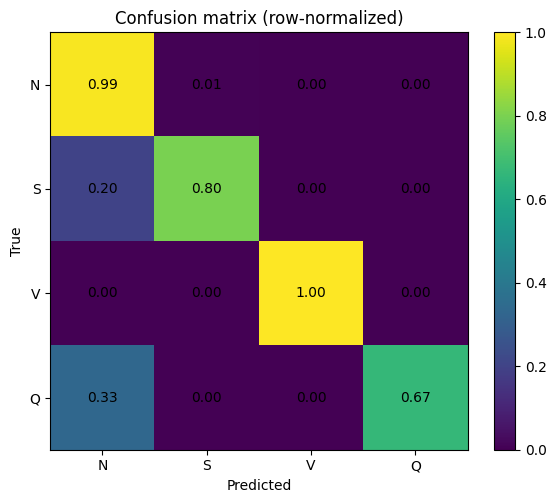

,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__CW_CAP,p__NOTES,p__AAMI_CLASSES,p__Q_rule,m__macro_f1,m__weighted_f1,m__recall_N,m__recall_S,m__recall_V,m__recall_Q
0,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860934,0.976060,0.974729,1.0,1.0,0.833333
1,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.798485,0.967789,0.974729,0.6,1.0,0.833333
2,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.310601,0.844736,0.776173,0.0,1.0,0.666667
3,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860929,0.979239,0.989170,0.8,1.0,0.666667


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__CW_CAP,p__NOTES,p__AAMI_CLASSES,p__Q_rule,m__macro_f1,m__weighted_f1,m__recall_N,m__recall_S,m__recall_V,m__recall_Q
0,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860934,0.976060,0.974729,1.0,1.0,0.833333
1,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.798485,0.967789,0.974729,0.6,1.0,0.833333
2,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.310601,0.844736,0.776173,0.0,1.0,0.666667
3,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,None,,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860929,0.979239,0.989170,0.8,1.0,0.666667


In [31]:
proba = model.predict({"signal": X_test, "rr": R_test})
y_pred = np.argmax(proba, axis=1)

print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))

macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
weighted_f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
print("Macro-F1:", macro_f1)
print("Weighted-F1:", weighted_f1)

cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(6,5))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
plt.colorbar(im)
ax.set_title("Confusion matrix (row-normalized)")
ax.set_xticks(range(len(AAMI_CLASSES))); ax.set_xticklabels(AAMI_CLASSES)
ax.set_yticks(range(len(AAMI_CLASSES))); ax.set_yticklabels(AAMI_CLASSES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()

recalls = {AAMI_CLASSES[i]: float(cm[i,i]) for i in range(len(AAMI_CLASSES))}

metrics = {
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    **{f"recall_{k}": v for k,v in recalls.items()},
}
log_run("AAMI_NSVQ", metrics, extra_params=TASK_PARAMS)


In [38]:
import numpy as np

def make_features(X, R, add_stats=True):
    # X: (n, L, 2), R: (n, 3)
    n, L, C = X.shape
    flat = X.reshape(n, L*C)

    feats = [flat, R]

    if add_stats:
        # kanal bazlı istatistikler: mean/std/min/max  (2 kanal -> 8 özellik)
        mean = X.mean(axis=1)
        std  = X.std(axis=1)
        mn   = X.min(axis=1)
        mx   = X.max(axis=1)
        stats = np.concatenate([mean, std, mn, mx], axis=1)
        feats.append(stats)

    return np.concatenate(feats, axis=1).astype(np.float32)

# test
print("make_features ready")


make_features ready


In [39]:
Xtr_f = make_features(X_train, R_train, add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)
print("Feature shapes:", Xtr_f.shape, Xte_f.shape)


Feature shapes: (1344, 217) (289, 217)


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix

def run_multiclass_model(name, clf, Xtr, ytr, Xte, yte, class_names):
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    clf.fit(Xtr_s, ytr)
    y_pred = clf.predict(Xte_s)

    macro_f1 = f1_score(yte, y_pred, average="macro", zero_division=0)
    weighted_f1 = f1_score(yte, y_pred, average="weighted", zero_division=0)

    print(f"\n== {name} ==")
    print(classification_report(yte, y_pred, target_names=class_names, digits=4, zero_division=0))
    print("Macro-F1:", macro_f1, "Weighted-F1:", weighted_f1)

    cm = confusion_matrix(yte, y_pred, normalize="true")
    recalls = {class_names[i]: float(cm[i,i]) for i in range(len(class_names))}
    metrics = {"macro_f1": float(macro_f1), "weighted_f1": float(weighted_f1),
               **{f"recall_{k}": v for k,v in recalls.items()}}

    try:
        extra = {"baseline": name, "feat_add_stats": True}
        log_run("AAMI_baseline", metrics, extra_params=extra)
    except Exception as e:
        print("RUN log skipped:", e)

    return metrics


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# 1) Multinomial Logistic Regression
logreg_mc = LogisticRegression(
    solver="saga", max_iter=8000,
    class_weight="balanced",
    multi_class="multinomial"
)

# 2) LinearSVC (multiclass)
svm_mc = LinearSVC(class_weight="balanced")

# 3) RandomForest
rf_mc = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced_subsample",
    random_state=PARAMS["RANDOM_STATE"],
    n_jobs=-1
)

_ = run_multiclass_model("LogReg_multinomial_balanced", logreg_mc, Xtr_f, y_train, Xte_f, y_test, AAMI_CLASSES)
_ = run_multiclass_model("LinearSVC_balanced", svm_mc, Xtr_f, y_train, Xte_f, y_test, AAMI_CLASSES)
_ = run_multiclass_model("RF_balanced", rf_mc, Xtr_f, y_train, Xte_f, y_test, AAMI_CLASSES)


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



== LogReg_multinomial_balanced ==
              precision    recall  f1-score   support

           N     0.9964    0.9892    0.9928       277
           S     0.5714    0.8000    0.6667         5
           V     1.0000    1.0000    1.0000         1
           Q     1.0000    1.0000    1.0000         6

    accuracy                         0.9862       289
   macro avg     0.8919    0.9473    0.9149       289
weighted avg     0.9891    0.9862    0.9873       289

Macro-F1: 0.9148550724637681 Weighted-F1: 0.9872874981194523


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__AAMI_CLASSES,p__Q_rule,m__macro_f1,m__weighted_f1,m__recall_N,m__recall_S,m__recall_V,m__recall_Q,p__baseline,p__feat_add_stats
0,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860934,0.976060,0.974729,1.0,1.0,0.833333,NaN,NaN
1,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.798485,0.967789,0.974729,0.6,1.0,0.833333,NaN,NaN
2,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.310601,0.844736,0.776173,0.0,1.0,0.666667,NaN,NaN
3,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860929,0.979239,0.989170,0.8,1.0,0.666667,NaN,NaN
4,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.914855,0.987287,0.989170,0.8,1.0,1.000000,LogReg_multinomial_balanced,True



== LinearSVC_balanced ==
              precision    recall  f1-score   support

           N     0.9928    0.9964    0.9946       277
           S     0.7500    0.6000    0.6667         5
           V     1.0000    1.0000    1.0000         1
           Q     1.0000    1.0000    1.0000         6

    accuracy                         0.9896       289
   macro avg     0.9357    0.8991    0.9153       289
weighted avg     0.9888    0.9896    0.9891       289

Macro-F1: 0.9153153153153153 Weighted-F1: 0.989052027806353


/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__AAMI_CLASSES,p__Q_rule,m__macro_f1,m__weighted_f1,m__recall_N,m__recall_S,m__recall_V,m__recall_Q,p__baseline,p__feat_add_stats
0,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860934,0.976060,0.974729,1.0,1.0,0.833333,NaN,NaN
1,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.798485,0.967789,0.974729,0.6,1.0,0.833333,NaN,NaN
2,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.310601,0.844736,0.776173,0.0,1.0,0.666667,NaN,NaN
3,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860929,0.979239,0.989170,0.8,1.0,0.666667,NaN,NaN
4,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.914855,0.987287,0.989170,0.8,1.0,1.000000,LogReg_multinomial_balanced,True
5,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.915315,0.989052,0.996390,0.6,1.0,1.000000,LinearSVC_balanced,True



== RF_balanced ==
              precision    recall  f1-score   support

           N     0.9823    1.0000    0.9911       277
           S     1.0000    0.2000    0.3333         5
           V     0.0000    0.0000    0.0000         1
           Q     1.0000    1.0000    1.0000         6

    accuracy                         0.9827       289
   macro avg     0.7456    0.5500    0.5811       289
weighted avg     0.9795    0.9827    0.9764       289

Macro-F1: 0.5810971973762671 Weighted-F1: 0.9764326229281569


,task,p__FS,p__PRE_S,p__POST_S,p__BP_LOW,p__BP_HIGH,p__BP_ORDER,p__RANDOM_STATE,p__TEST_SIZE,p__VAL_FROM_TMP,...,p__AAMI_CLASSES,p__Q_rule,m__macro_f1,m__weighted_f1,m__recall_N,m__recall_S,m__recall_V,m__recall_Q,p__baseline,p__feat_add_stats
0,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860934,0.976060,0.974729,1.0,1.0,0.833333,NaN,NaN
1,AAMI_NSVQ,128,0.25,0.45,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.798485,0.967789,0.974729,0.6,1.0,0.833333,NaN,NaN
2,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.310601,0.844736,0.776173,0.0,1.0,0.666667,NaN,NaN
3,AAMI_NSVQ,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,"[N, S, V, Q]","~,|,F -> Q (record800)",0.860929,0.979239,0.989170,0.8,1.0,0.666667,NaN,NaN
4,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.914855,0.987287,0.989170,0.8,1.0,1.000000,LogReg_multinomial_balanced,True
5,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.915315,0.989052,0.996390,0.6,1.0,1.000000,LinearSVC_balanced,True
6,AAMI_baseline,128,0.30,0.50,0.5,40.0,4,42,0.3,0.5,...,NaN,NaN,0.581097,0.976433,1.000000,0.2,0.0,1.000000,RF_balanced,True
